In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as tfms
from torch.utils.data import DataLoader, Dataset

from PIL import Image
import cv2
import sys
import os

sys.path.insert(1, os.path.dirname(os.getcwd()))

from models.resnet import ResNetModified, Bottleneck
from utils.custom_datasets import CustomImageDataset
# medical images
# train_set_path = "/Users/mitrylitvin/School/Erasmus/PROJECT_S8/nerf-optique/data/dataset/train_test_full_roi/train_data/img_224/"
# test_set_path = "/Users/mitrylitvin/School/Erasmus/PROJECT_S8/nerf-optique/data/dataset/train_test_full_roi/test_data/img_224/"
train_set_path = "/Users/mitrylitvin/School/Erasmus/PROJECT_S8/nerf-optique/data/dataset/train_test_full_roi/train_data/images/"
test_set_path = "/Users/mitrylitvin/School/Erasmus/PROJECT_S8/nerf-optique/data/dataset/train_test_full_roi/test_data/images/"


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    # npimg = img.numpy()
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
block = Bottleneck
layers = [3, 4, 23, 3]

resnet_modified = ResNetModified(block, layers)
model_pretrained = tv.models.resnet101(weights=tv.models.ResNet101_Weights.IMAGENET1K_V1)

upsmpl = nn.Upsample(scale_factor=4, mode = 'bicubic')

In [17]:
for layer_mod, layer_mod_trained in zip(resnet_modified.modules(), model_pretrained.modules()):
    if isinstance(layer_mod, nn.Conv2d):
        layer_mod.weight = layer_mod_trained.weight
        layer_mod.requires_grad_(False)
    
    if isinstance(layer_mod, nn.Linear):
        layer_mod.weight = layer_mod_trained.weight
        layer_mod.bias = layer_mod_trained.bias
        layer_mod.requires_grad_(False)

    if isinstance(layer_mod, nn.BatchNorm2d):
        layer_mod.weight = layer_mod_trained.weight
        layer_mod.bias = layer_mod_trained.bias
        layer_mod.requires_grad_(False)

In [18]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transform = tfms.Compose([tfms.ToTensor(),  tfms.Normalize(mean, std)])
 
train_dataset = CustomImageDataset(train_set_path, transform=data_transform)

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [33]:
img_medic = train_dataset[0]['image']
img_medic.requires_grad_(False)
img_medic.shape
x = resnet_modified(img_medic)
x = upsmpl(x)
x_normed = x / torch.sqrt((x**2).sum(axis=1).unsqueeze(1))
x_normed = x_normed.squeeze(0)
x_reshaped = torch.reshape(x_normed, (x_normed.shape[0], x_normed.shape[1] * x_normed.shape[2]))
X = x_reshaped.T
X.shape

torch.Size([236096, 256])

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
X = pca.fit_transform(X)
X.shape

(50176, 30)

In [12]:
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import DBSCAN
from sklearn import metrics

X = StandardScaler().fit_transform(X)

db = DBSCAN(
    eps=0.05,
    min_samples=40, 
    metric='euclidean', 
    metric_params=None, 
    algorithm='auto', 
    leaf_size=30, 
    p=None, 
    n_jobs=None).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 18
Estimated number of noise points: 48245


In [33]:
# print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
# print(f"Completeness: {metrics.completeness_score(labels_true, labels):.3f}")
# print(f"V-measure: {metrics.v_measure_score(labels_true, labels):.3f}")
# print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels):.3f}")
# print(
#     "Adjusted Mutual Information:"
#     f" {metrics.adjusted_mutual_info_score(labels_true, labels):.3f}"
# )
# print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

In [16]:
# unique_labels = set(labels)
# core_samples_mask = np.zeros_like(labels, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True

# colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = labels == k

#     xy = X[class_member_mask & core_samples_mask]
#     plt.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor="k",
#         markersize=14,
#     )

#     xy = X[class_member_mask & ~core_samples_mask]
#     plt.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor="k",
#         markersize=6,
#     )

# plt.title(f"Estimated number of clusters: {n_clusters_}")
# plt.show()

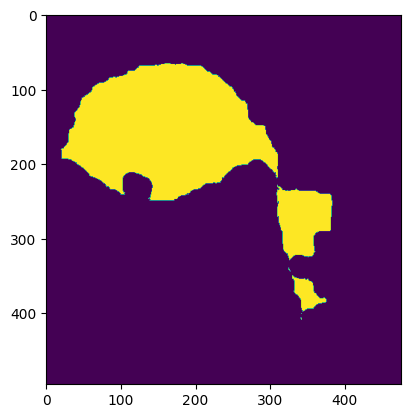

In [34]:
X_clustered = np.reshape(labels, ((1, x_normed.shape[1], x_normed.shape[2])))
plt.imshow(X_clustered.transpose(1, 2, 0))

In [7]:
import hdbscan

In [8]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=False)
clusterer.fit(X)

HDBSCAN()

In [12]:
labels = clusterer.labels_

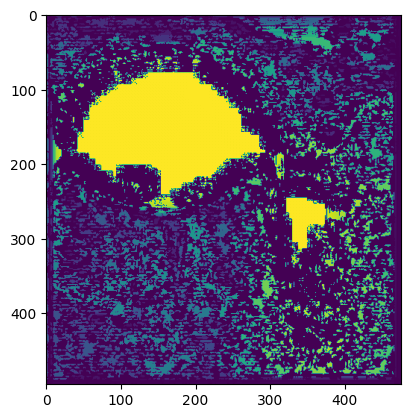

In [13]:
X_clustered = np.reshape(labels, ((1, x_normed.shape[1], x_normed.shape[2])))
plt.imshow(X_clustered.transpose(1, 2, 0))

In [13]:
from sklearn.cluster import AffinityPropagation

In [29]:
from sklearn.cluster import BisectingKMeans
n_clusters = 5
kmeans = BisectingKMeans(
    init="random",
    # init="k-means++",
    bisecting_strategy="biggest_inertia",
    n_clusters=n_clusters,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [30]:
kmeans.fit(X)

BisectingKMeans(n_clusters=5, n_init=10, random_state=42)

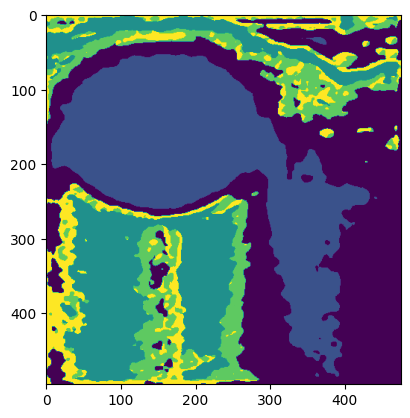

In [31]:
X_clustered = np.reshape(kmeans.labels_, ((1, x_normed.shape[1], x_normed.shape[2])))
plt.imshow(X_clustered.transpose(1, 2, 0))

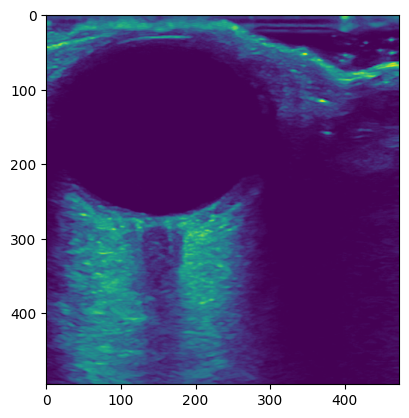

In [27]:
plt.imshow(img_medic.squeeze(0).numpy().transpose(1, 2, 0)[..., :3] @ [0.33, 0.33, 0.33])

In [32]:
from sklearn.cluster import OPTICS
opt = OPTICS()

In [36]:
opt.fit(X)